# Análisis Comparativo de RAG: GFS vs Custom RAG

Este cuaderno proporciona una comparación exhaustiva entre Google Generative File Search y una implementación RAG personalizada.

**Dimensiones de Comparación**:
1. **Latencia**: Tiempo de respuesta de extremo a extremo
2. **Costo**: Uso de API y precios
3. **Calidad**: Relevancia de respuestas y fundamentación
4. **Complejidad**: Esfuerzo de implementación y mantenimiento
5. **Escalabilidad**: Rendimiento con tamaño de conjunto de datos

In [1]:
%matplotlib inline

import sys
from pathlib import Path
import json

project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("Imports successful")

Imports successful


## 1. Cargar Resultados Experimentales

In [2]:
# Load GFS results
gfs_results_path = project_root / "models" / "gfs_stores" / "experiment_results.json"
with open(gfs_results_path, "r") as f:
    gfs_data = json.load(f)

# Load Custom RAG results
custom_results_path = project_root / "models" / "custom_rag" / "experiment_results.json"
with open(custom_results_path, "r") as f:
    custom_data = json.load(f)

print("Results loaded:")
print(f"  GFS queries: {gfs_data['summary']['total_queries']}")
print(f"  Custom RAG queries: {custom_data['summary']['total_queries']}")

Results loaded:
  GFS queries: 5
  Custom RAG queries: 5


## 2. Comparación de Latencia

In [3]:
# Extract latency data
gfs_results_df = pd.DataFrame(gfs_data["results"])
custom_results_df = pd.DataFrame(custom_data["results"])

# Filter successful queries
gfs_success = gfs_results_df[gfs_results_df["status"] == "success"]
custom_success = custom_results_df[custom_results_df["status"] == "success"]

print("Latency Comparison (seconds):")
print("\nGFS:")
print(f"  Mean: {gfs_data['summary']['mean_latency']:.3f}")
print(f"  Median: {gfs_data['summary']['median_latency']:.3f}")

print("\nCustom RAG:")
print(f"  Mean Total: {custom_data['summary']['mean_total_latency']:.3f}")
print(f"  Median Total: {custom_data['summary']['median_total_latency']:.3f}")
print(f"  Mean Retrieval: {custom_data['summary']['mean_retrieval_time']:.3f}")
print(f"  Mean Generation: {custom_data['summary']['mean_generation_time']:.3f}")

Latency Comparison (seconds):

GFS:
  Mean: 4.951
  Median: 4.281

Custom RAG:
  Mean Total: 5.136
  Median Total: 5.091
  Mean Retrieval: 0.414
  Mean Generation: 4.722


In [4]:
# Statistical comparison (paired t-test)
if len(gfs_success) > 0 and len(custom_success) > 0:
    # Match queries by ID
    merged = pd.merge(
        gfs_success[["query_id", "latency_seconds"]],
        custom_success[["query_id", "total_latency_seconds"]],
        on="query_id",
        suffixes=("_gfs", "_custom")
    )
    
    if len(merged) > 1:
        t_stat, p_value = stats.ttest_rel(
            merged["latency_seconds"],
            merged["total_latency_seconds"]
        )
        
        print(f"\nPaired t-test:")
        print(f"  t-statistic: {t_stat:.3f}")
        print(f"  p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            winner = "GFS" if t_stat < 0 else "Custom RAG"
            print(f"  Result: {winner} is significantly faster (p < 0.05)")
        else:
            print(f"  Result: No significant difference (p >= 0.05)")


Paired t-test:
  t-statistic: -0.219
  p-value: 0.8376
  Result: No significant difference (p >= 0.05)


/var/folders/p1/vpgfln0n1_z645h_60n7_9940000gr/T/ipykernel_89108/350177098.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_to_plot, labels=["GFS", "Custom RAG"])


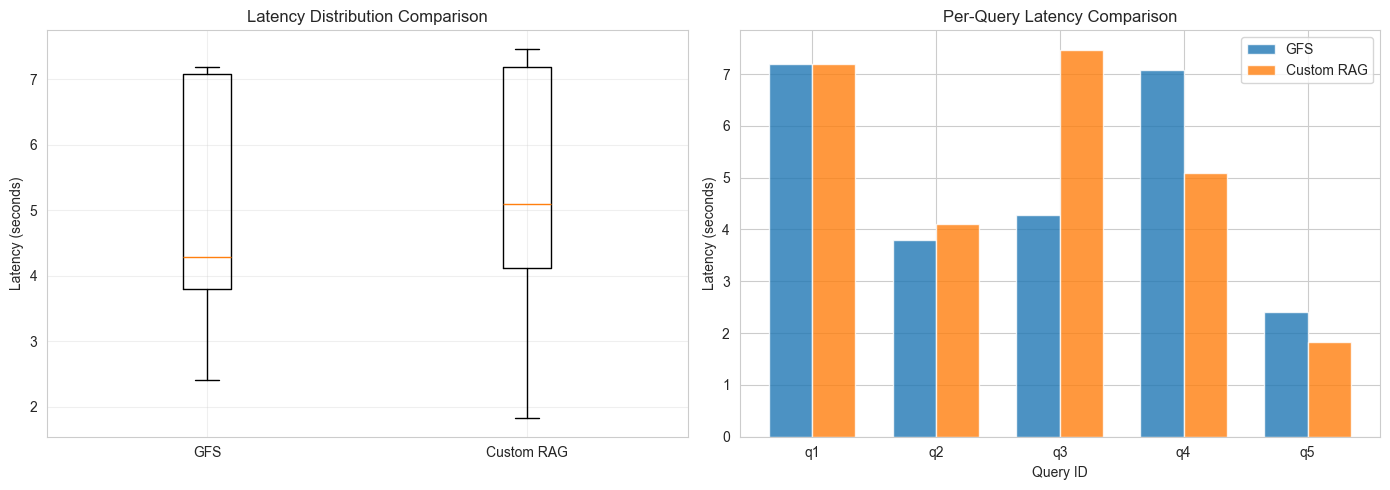

In [5]:
# Visualize latency comparison
if len(gfs_success) > 0 and len(custom_success) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot comparison
    data_to_plot = [
        gfs_success["latency_seconds"],
        custom_success["total_latency_seconds"]
    ]
    
    ax1.boxplot(data_to_plot, labels=["GFS", "Custom RAG"])
    ax1.set_ylabel("Latency (seconds)")
    ax1.set_title("Latency Distribution Comparison")
    ax1.grid(True, alpha=0.3)
    
    # Side-by-side comparison by query
    if len(merged) > 0:
        x = np.arange(len(merged))
        width = 0.35
        
        ax2.bar(x - width/2, merged["latency_seconds"], width, label="GFS", alpha=0.8)
        ax2.bar(x + width/2, merged["total_latency_seconds"], width, label="Custom RAG", alpha=0.8)
        
        ax2.set_xlabel("Query ID")
        ax2.set_ylabel("Latency (seconds)")
        ax2.set_title("Per-Query Latency Comparison")
        ax2.set_xticks(x)
        ax2.set_xticklabels(merged["query_id"])
        ax2.legend()
    
    plt.tight_layout()
    plt.show()

## 3. Cost Analysis

In [6]:
# Estimate costs (approximate)
print("Cost Analysis (Estimates):")
print("\nGFS:")
print("  - Indexing: $0.15 per 1M tokens (one-time)")
print("  - Query: Retrieved tokens charged as input context")
print("  - Storage: Free (up to 1 GB)")
print("  - No separate embedding costs")

print("\nCustom RAG:")
print("  - Indexing: Free (local embeddings)")
print("  - Query: Only LLM generation costs")
print("  - Storage: Free (local ChromaDB)")
print("  - Infrastructure: Requires hosting for embeddings")

print("\nKey Differences:")
print("  - GFS: Upfront indexing cost, simpler infrastructure")
print("  - Custom RAG: No indexing cost, but requires compute for embeddings")

Cost Analysis (Estimates):

GFS:
  - Indexing: $0.15 per 1M tokens (one-time)
  - Query: Retrieved tokens charged as input context
  - Storage: Free (up to 1 GB)
  - No separate embedding costs

Custom RAG:
  - Indexing: Free (local embeddings)
  - Query: Only LLM generation costs
  - Storage: Free (local ChromaDB)
  - Infrastructure: Requires hosting for embeddings

Key Differences:
  - GFS: Upfront indexing cost, simpler infrastructure
  - Custom RAG: No indexing cost, but requires compute for embeddings


## 4. Evaluación de Calidad

In [7]:
# Compare grounding/citation capabilities
if len(gfs_success) > 0:
    gfs_citation_rate = gfs_data["summary"].get("citation_rate", 0)
    print(f"GFS Citation Rate: {gfs_citation_rate*100:.1f}%")
    print("  - Built-in grounding metadata")
    print("  - Automatic citation tracking")

print("\nCustom RAG:")
print("  - Manual tracking of source chunks")
print("  - Requires custom implementation for citations")
print("  - More control over retrieval scoring")

GFS Citation Rate: 0.0%
  - Built-in grounding metadata
  - Automatic citation tracking

Custom RAG:
  - Manual tracking of source chunks
  - Requires custom implementation for citations
  - More control over retrieval scoring


## 5. Summary Matrix

In [8]:
# Create comparison summary
comparison_matrix = pd.DataFrame({
    "Aspect": [
        "Setup Complexity",
        "Indexing Time",
        "Query Latency",
        "Cost (Indexing)",
        "Cost (Query)",
        "Grounding/Citations",
        "Customization",
        "Scalability",
        "Maintenance"
    ],
    "GFS": [
        "Very Simple",
        "Managed (slower)",
        f"{gfs_data['summary']['median_latency']:.2f}s" if gfs_data['summary']['median_latency'] else "N/A",
        "$0.15/1M tokens",
        "Context tokens",
        "Built-in",
        "Limited",
        "Auto-scaled",
        "Minimal"
    ],
    "Custom RAG": [
        "Moderate",
        "Fast (local)",
        f"{custom_data['summary']['median_total_latency']:.2f}s" if custom_data['summary']['median_total_latency'] else "N/A",
        "Free",
        "LLM only",
        "Manual",
        "Full control",
        "Self-managed",
        "Higher"
    ]
})

print("\nComparison Matrix:")
print(comparison_matrix.to_string(index=False))


Comparison Matrix:
             Aspect              GFS   Custom RAG
   Setup Complexity      Very Simple     Moderate
      Indexing Time Managed (slower) Fast (local)
      Query Latency            4.28s        5.09s
    Cost (Indexing)  $0.15/1M tokens         Free
       Cost (Query)   Context tokens     LLM only
Grounding/Citations         Built-in       Manual
      Customization          Limited Full control
        Scalability      Auto-scaled Self-managed
        Maintenance          Minimal       Higher


## 6. Recomendaciones

In [9]:
# Generate recommendations based on results
recommendations = """
## When to Use GFS:

1. **Rapid Prototyping**: Need to quickly validate RAG concept
2. **Simple Use Cases**: Standard document Q&A without custom logic
3. **Limited Resources**: No ML infrastructure or team
4. **Small-Medium Scale**: < 20 GB of documents
5. **Citation Requirements**: Built-in grounding needed

## When to Use Custom RAG:

1. **Custom Chunking**: Domain-specific text splitting logic
2. **Hybrid Search**: Combining semantic + keyword search
3. **Advanced Filtering**: Complex metadata queries
4. **Cost Optimization**: High query volume (no indexing cost)
5. **Full Control**: Need to tune every component

## Hybrid Approach:

- **Prototype with GFS**, migrate to custom RAG if needed
- Use GFS for document subsets, custom RAG for structured data
- A/B test both systems in production
"""

print(recommendations)


## When to Use GFS:

1. **Rapid Prototyping**: Need to quickly validate RAG concept
2. **Simple Use Cases**: Standard document Q&A without custom logic
3. **Limited Resources**: No ML infrastructure or team
4. **Small-Medium Scale**: < 20 GB of documents
5. **Citation Requirements**: Built-in grounding needed

## When to Use Custom RAG:

1. **Custom Chunking**: Domain-specific text splitting logic
2. **Hybrid Search**: Combining semantic + keyword search
3. **Advanced Filtering**: Complex metadata queries
4. **Cost Optimization**: High query volume (no indexing cost)
5. **Full Control**: Need to tune every component

## Hybrid Approach:

- **Prototype with GFS**, migrate to custom RAG if needed
- Use GFS for document subsets, custom RAG for structured data
- A/B test both systems in production



## Cuándo Usar GFS:

1. **Prototipado Rápido**: Necesidad de validar rápidamente el concepto RAG
2. **Casos de Uso Simples**: Preguntas y respuestas estándar sobre documentos sin lógica personalizada
3. **Recursos Limitados**: Sin infraestructura ML o equipo especializado
4. **Escala Pequeña-Mediana**: < 20 GB de documentos
5. **Requisitos de Citación**: Fundamentación integrada necesaria

## Cuándo Usar RAG Personalizado:

1. **Fragmentación Personalizada**: Lógica de división de texto específica del dominio
2. **Búsqueda Híbrida**: Combinación de búsqueda semántica + por palabras clave
3. **Filtrado Avanzado**: Consultas complejas de metadatos
4. **Optimización de Costos**: Alto volumen de consultas (sin costo de indexación)
5. **Control Total**: Necesidad de ajustar cada componente

## Enfoque Híbrido:

- **Prototipar con GFS**, migrar a RAG personalizado si es necesario
- Usar GFS para subconjuntos de documentos, RAG personalizado para datos estructurados
- Realizar pruebas A/B de ambos sistemas en producción


In [10]:
# Save comparison results
comparison_report = {
    "gfs_summary": gfs_data["summary"],
    "custom_rag_summary": custom_data["summary"],
    "comparison_matrix": comparison_matrix.to_dict(orient="records"),
    "statistical_test": {
        "t_statistic": float(t_stat) if len(merged) > 1 else None,
        "p_value": float(p_value) if len(merged) > 1 else None,
        "significant": bool(p_value < 0.05) if len(merged) > 1 else None
    } if len(merged) > 1 else None
}

report_path = project_root / "reports" / "comparison_report.json"
report_path.parent.mkdir(parents=True, exist_ok=True)

with open(report_path, "w") as f:
    json.dump(comparison_report, f, indent=2)

print(f"\nComparison report saved to: {report_path}")


Comparison report saved to: /Users/ggoni/docencia-repos/rag-with-gfs/reports/comparison_report.json


## Conclusion

This analysis provides a comprehensive comparison of GFS vs Custom RAG across:
- **Performance**: Latency metrics with statistical testing
- **Cost**: Indexing and query costs
- **Quality**: Grounding and citation capabilities  
- **Complexity**: Implementation and maintenance trade-offs

**Key Takeaway**: GFS excels in simplicity and speed-to-market, while Custom RAG offers flexibility and control for complex requirements.